In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from __future__ import division
from collections import defaultdict
import os
import argparse
import numpy as np
import pandas as pd
# import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import comptools as comp

color_dict = comp.get_color_dict()

%matplotlib inline

In [4]:
config = 'IC86.2012'
sims = comp.simfunctions.config_to_sim(config)
sigmoid = 'slant'
num_groups = 2
comp_list = comp.get_comp_list(num_groups=num_groups)

In [5]:
energybins = comp.get_energybins(config=config)
energy_comp_bins = comp.get_bins(config=config, num_groups=num_groups)
energy_comp_bins

[array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
        7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ]), array([0, 1, 2])]

In [6]:
# Want to include energy bins for energies below the normal analysis energy
# range so we can get a better estimate of how the detector efficiencies turn on
low_energy_bins = np.arange(5.0, energybins.log_energy_min, 0.1)
ebins = np.concatenate((low_energy_bins, energybins.log_energy_bins))
ebin_midpoints = (ebins[1:] + ebins[:-1]) / 2

In [7]:
comp_bins = np.arange(num_groups + 1)
comp_bins

array([0, 1, 2])

In [8]:
bins = [ebins, comp_bins]
bins

[array([5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
        6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5,
        7.6, 7.7, 7.8, 7.9, 8. ]), array([0, 1, 2])]

In [9]:
df_sim = comp.load_sim(config=config,
                       test_size=0,
                       log_energy_min=None,
                       log_energy_max=None,
                       verbose=True)

[#                                       ] | 3% Completed |  0.1s

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  0.1s


In [10]:
# Thrown areas are different for different energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(ebin_midpoints)
thrown_areas = np.pi * thrown_radii**2
thrown_areas_max = thrown_areas.max()
thrown_areas_max

9079202.768874502

In [11]:
columns = ['MC_log_energy', 'comp_target_{}'.format(num_groups)]
passed_showers, _ = np.histogramdd(df_sim.loc[:, columns].values, bins=bins)

In [13]:
# coords = [ebin_midpoints, np.arange(num_groups)]
# dims = ['MC_log_energy', 'composition']

In [14]:
# passed_showers = xr.DataArray(passed_showers, coords=coords, dims=dims)
# passed_showers

In [12]:
def thrown_showers_per_ebin(sim_list, log_energy_bins=None):
    """Calculate the number of thrown showers in each energy bin

    Parameters
    ----------
    sim_list : array_like
        Sequence of simulation dataset numbers.
    log_energy_bins : array_like or None, optional
        Log energy bins to use (defaults to np.arange(5, 8.1, 0.1)).

    Returns
    -------
    thrown_showers : np.ndarray
        Array containing the number of thrown showers in each energy bin.
    """
    if isinstance(sim_list, int):
        sim_list = [sim_list]
    e_bins = []
    for sim in sim_list:
        file_iter = comp.simfunctions.get_level3_sim_files_iterator(sim)
        runs = (sim_file_to_run(f) for f in file_iter)
        for run in runs:
            e_bin = comp.simfunctions.run_to_energy_bin(run, sim)
            e_bins.append(e_bin)

    if log_energy_bins is None:
        log_energy_bins = np.arange(5, 8.1, 0.1)
    vals, _ = np.histogram(e_bins, bins=log_energy_bins)

    n_resamples = 100
    n_showers_per_file = n_resamples
    thrown_showers = vals * n_showers_per_file

    return thrown_showers

In [13]:
def sim_file_to_run(file):
    """Extracts run number from a simulation file path

    Parameters
    ----------
    file : str
        Simulation file path.

    Returns
    -------
    run : int
        Run number for simulation file

    Examples
    --------
    >>> file = '/data/ana/CosmicRay/IceTop_level3/sim/IC79/7241/Level3_IC79_7241_Run005347.i3.gz'
    >>> sim_file_to_run(file)
    5347
    """
    start_idx = file.find('Run')
    run = int(file[start_idx+3: start_idx+9])
    return run

In [14]:
# Calculate efficiencies and effective areas for each composition group
thrown_showers = np.zeros_like(passed_showers)   
for idx, composition in enumerate(comp_list):
# for composition in comp_list + ['total']:
    compositions = df_sim['comp_group_{}'.format(num_groups)]
    # Need list of simulation sets for composition to get number of thrown showers
    comp_mask = compositions == composition
    sim_list = df_sim.loc[comp_mask, 'sim'].unique()
    thrown_showers[:, idx] = thrown_showers_per_ebin(sim_list, log_energy_bins=ebins)
thrown_showers

array([[132900., 132900.],
       [132900., 132800.],
       [132700., 133000.],
       [132100., 132400.],
       [132900., 132600.],
       [132900., 132800.],
       [132600., 132700.],
       [131900., 132800.],
       [132300., 132300.],
       [131500., 132100.],
       [132300., 132600.],
       [132600., 132100.],
       [132600., 131300.],
       [132200., 132000.],
       [131900., 132400.],
       [131600., 131300.],
       [130900., 132200.],
       [131100., 132000.],
       [131700., 132200.],
       [131500., 132000.],
       [130600., 132000.],
       [131400., 132300.],
       [132200., 132000.],
       [131800., 131400.],
       [131600., 131600.],
       [131400., 132100.],
       [131900., 132000.],
       [130300., 131000.],
       [131300., 132100.],
       [131200., 131200.]])

In [15]:
# thrown_showers = xr.DataArray(thrown_showers, coords=coords, dims=dims)
# thrown_showers

In [16]:
thrown_radius_factor = thrown_areas / thrown_areas_max
thrown_radius_factor

array([0.22145329, 0.22145329, 0.22145329, 0.22145329, 0.22145329,
       0.22145329, 0.22145329, 0.22145329, 0.22145329, 0.22145329,
       0.41868512, 0.41868512, 0.41868512, 0.41868512, 0.41868512,
       0.41868512, 0.41868512, 0.41868512, 0.41868512, 0.41868512,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [17]:
efficiency, efficiency_err = comp.ratio_error(num=passed_showers,
                                              num_err=np.sqrt(passed_showers),
                                              den=thrown_showers,
                                              den_err=np.sqrt(thrown_showers),
                                              nan_to_num=True)

# efficiency_err = xr.DataArray(efficiency_err, coords=coords, dims=dims)

efficiency = efficiency * thrown_radius_factor.reshape(-1, 1)
efficiency_err = efficiency_err * thrown_radius_factor.reshape(-1, 1)

/home/jbourbeau/cr-composition/comptools/data_functions.py:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)


In [18]:
efficiency

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [3.35281283e-06, 1.67260791e-06],
       [4.99894553e-05, 6.68034049e-06],
       [1.16642062e-04, 3.16838287e-05],
       [4.12511025e-04, 1.25161994e-04],
       [1.06109536e-03, 4.18560053e-04],
       [2.47230919e-03, 1.15162405e-03],
       [4.43411791e-03, 2.80798074e-03],
       [5.48436368e-03, 4.36051397e-03],
       [7.18016565e-03, 6.47836781e-03],
       [7.92533676e-03, 7.29908791e-03],
       [8.49721770e-03, 8.08189158e-03],
       [7.90708595e-03, 8.93342498e-03],
       [8.66321873e-03, 7.90495366e-03],
       [9.56674711e-03, 8.24702009e-03],
       [9.39566458e-03, 9.37283737e-03],
       [9.09535407e-03, 8.38320360e-03],
       [8.70482982e-03, 8.83044983e-03],
       [8.57580398e-03, 9.34090909e-03],
       [9.33789954e-03, 8.25396825e-03],
       [8.27534039e-03, 9.03787879e-03],
       [9.28679818e-03, 8.83561644e-03],
       [8.107902

In [19]:
efficiency_err

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [2.37081463e-06, 1.67261423e-06],
       [9.12781416e-06, 3.34022062e-06],
       [1.39450641e-05, 7.26928878e-06],
       [2.62718828e-05, 1.44565457e-05],
       [4.23091064e-05, 2.64442315e-05],
       [6.46879426e-05, 4.40192675e-05],
       [8.72743756e-05, 6.90434986e-05],
       [1.32602866e-04, 1.17948029e-04],
       [1.51855872e-04, 1.44397400e-04],
       [1.59680855e-04, 1.53885849e-04],
       [1.65702587e-04, 1.61646001e-04],
       [1.59916137e-04, 1.69860841e-04],
       [1.67726894e-04, 1.60259091e-04],
       [1.76913900e-04, 1.63197020e-04],
       [1.75156103e-04, 1.74341133e-04],
       [1.71880812e-04, 1.64565184e-04],
       [1.68201328e-04, 1.69114333e-04],
       [2.57347591e-04, 2.67255434e-04],
       [2.67821357e-04, 2.50805147e-04],
       [2.51227270e-04, 2.62845185e-04],
       [2.66675179e-04, 2.60453950e-04],
       [2.492182

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


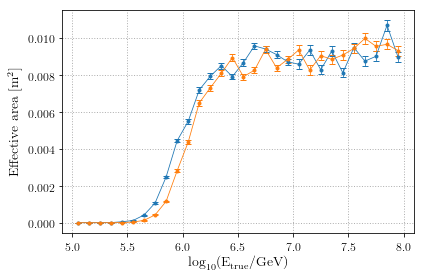

In [20]:
fig, ax = plt.subplots()
for idx, composition in enumerate(comp_list):
    eff = efficiency[:, idx]
    eff_err = efficiency_err[:, idx]
    ax.errorbar(ebin_midpoints, eff, yerr=eff_err, color=color_dict[composition], label=composition)
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Effective area [$\mathrm{m^2}$]')
ax.grid()
plt.show()

## Fit efficieny curves

In [21]:
def sigmoid_flat(log_energy, p0, p1, p2):
    return p0 / (1 + np.exp(-p1*log_energy + p2))


def sigmoid_slant(log_energy, p0, p1, p2, p3):
    '''Fit function for effective area vs. energy

    Parameters
    ----------
    log_energy : numpy.ndarray
        Log energy values

    '''
    return (p0 + p3*log_energy) / (1 + np.exp(-p1*log_energy + p2))

In [22]:
# Fit sigmoid function to efficiency vs. energy distribution
fit_func = sigmoid_flat if sigmoid == 'flat' else sigmoid_slant
p0 = [7e4, 8.0, 50.0] if sigmoid == 'flat' else [7e4, 8.5, 50.0, 800]

In [23]:
energy_min_fit, energy_max_fit = 5.8, energybins.log_energy_max

fit_energy_range_mask = (ebin_midpoints < energy_max_fit) & (ebin_midpoints > energy_min_fit)
fit_energy_range_mask

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [24]:
# # Fit sigmoid function to efficiency vs. energy distribution
# fit_func = sigmoid_flat if sigmoid == 'flat' else sigmoid_slant
# p0 = [7e4, 8.0, 50.0] if sigmoid == 'flat' else [7e4, 8.5, 50.0, 800]
# efficiencies_fit = {}
# energy_min_fit, energy_max_fit = 5.8, energybins.log_energy_max
# emidpoints_fitmask = np.logical_and(ebin_midpoints > energy_min_fit,
#                                     ebin_midpoints < energy_max_fit)
# ebin_midpoints_fit = ebin_midpoints[emidpoints_fitmask]
# ebin_midpoints_fit

In [25]:
# Find best-fit sigmoid function
# efficiency_fit = {}
efficiency_fit = np.empty_like(efficiency[fit_energy_range_mask])
# efficiency_fit = xr.zeros_like(efficiency[fit_energy_range_mask])
for idx, composition in enumerate(comp_list):
    popt, pcov = curve_fit(fit_func,
                           ebin_midpoints[fit_energy_range_mask],
                           efficiency[fit_energy_range_mask, idx],
                           sigma=efficiency_err[fit_energy_range_mask, idx],
                           p0=p0)
    eff_fit = fit_func(ebin_midpoints[fit_energy_range_mask], *popt)
#     eff_fit = fit_func(ebin_midpoints[emidpoints_fitmask], *popt)
    efficiency_fit[:, idx] = eff_fit

    chi2 = np.nansum((efficiency[fit_energy_range_mask, idx] - eff_fit)**2 / (efficiency_err[fit_energy_range_mask, idx]) ** 2)
    ndof = len(eff_fit) - len(p0)
#     print('({}) chi2 / ndof = {} / {} = {}'.format(composition,
#                                                    chi2,
#                                                    ndof,
#                                                    chi2 / ndof))
efficiency_fit

array([[0.00256468, 0.00120883],
       [0.004168  , 0.00263449],
       [0.00582488, 0.00462157],
       [0.00711697, 0.0063948 ],
       [0.00792644, 0.00747196],
       [0.00837232, 0.00800669],
       [0.00860699, 0.00827068],
       [0.00873362, 0.00842221],
       [0.00880826, 0.00853026],
       [0.00885857, 0.00862197],
       [0.00889765, 0.00870759],
       [0.00893158, 0.00879095],
       [0.00896315, 0.00887348],
       [0.00899363, 0.0089557 ],
       [0.00902363, 0.0090378 ],
       [0.0090534 , 0.00911986],
       [0.00908307, 0.0092019 ],
       [0.00911269, 0.00928394],
       [0.00914229, 0.00936597],
       [0.00917188, 0.00944801],
       [0.00920146, 0.00953004],
       [0.00923104, 0.00961208]])

In [50]:
# Perform many fits to random statistical fluxuations of the best fit efficiency
# This will be used to estimate the uncertainty in the best fit efficiency
eff_fit = np.empty_like(efficiency_fit)
eff_fit_err = np.empty_like(eff_fit)
# efficiencies_fit_samples = defaultdict(list)
n_samples = 1000
for comp_idx, composition in enumerate(comp_list):
    eff_fit_samples = []
    for _ in range(n_samples):

        # Get new random sample to fit
        eff_sample = np.random.normal(efficiency_fit[:, comp_idx],
#                                       efficiency_err[bin_midpoints_mask, idx])
                                      efficiency_err[fit_energy_range_mask, comp_idx])
        # Fit with error bars
        popt, pcov = curve_fit(fit_func,
                               ebin_midpoints[fit_energy_range_mask],
                               eff_sample,
                               p0=p0,
#                                sigma=efficiency_err[bin_midpoints_mask, idx])
                               sigma=efficiency_err[fit_energy_range_mask, comp_idx])

        eff_fit_samples.append(fit_func(ebin_midpoints[fit_energy_range_mask], *popt))
#     efficiencies_fit_samples[composition].append(eff_fit_sample)
    eff_fit[:, comp_idx] = np.mean(eff_fit_samples, axis=0)
    eff_fit_err[:, comp_idx] = np.std(eff_fit_samples, axis=0)

In [51]:
eff_fit

array([[0.00256387, 0.00120655],
       [0.00416869, 0.00263227],
       [0.00582595, 0.00462067],
       [0.00711648, 0.00639353],
       [0.00792472, 0.00747015],
       [0.00837055, 0.00800534],
       [0.00860573, 0.00827011],
       [0.00873291, 0.00842231],
       [0.00880792, 0.00853085],
       [0.0088584 , 0.00862292],
       [0.00889751, 0.00870882],
       [0.00893136, 0.00879243],
       [0.00896279, 0.00887518],
       [0.0089931 , 0.00895761],
       [0.00902289, 0.00903992],
       [0.00905245, 0.00912219],
       [0.0090819 , 0.00920444],
       [0.0091113 , 0.00928668],
       [0.00914067, 0.00936892],
       [0.00917003, 0.00945116],
       [0.00919939, 0.0095334 ],
       [0.00922875, 0.00961564]])

In [52]:
eff_fit_err

array([[5.71184062e-05, 3.88955627e-05],
       [5.71966524e-05, 4.52035918e-05],
       [8.12542450e-05, 7.52086734e-05],
       [8.13397477e-05, 8.01800489e-05],
       [6.91328387e-05, 6.62611722e-05],
       [6.56935808e-05, 6.51612713e-05],
       [6.74865410e-05, 6.72383658e-05],
       [6.75351289e-05, 6.58559069e-05],
       [6.48642076e-05, 6.21733524e-05],
       [6.07538957e-05, 5.80999127e-05],
       [5.66647155e-05, 5.49414541e-05],
       [5.37924639e-05, 5.34869241e-05],
       [5.29820066e-05, 5.41167565e-05],
       [5.46297589e-05, 5.68468659e-05],
       [5.86585567e-05, 6.14256342e-05],
       [6.46763936e-05, 6.74864008e-05],
       [7.22070069e-05, 7.46716770e-05],
       [8.08356068e-05, 8.26895213e-05],
       [9.02501055e-05, 9.13210670e-05],
       [1.00229965e-04, 1.00408199e-04],
       [1.10622424e-04, 1.09837902e-04],
       [1.21321494e-04, 1.19529121e-04]])

In [53]:
# # Calculate median and error of efficiency fits
# eff_fit = pd.DataFrame()
# # eff_fit = xr.zeros_like(efficiency_fit)
# for composition in comp_list:
# #     comp_mask = eff_fit.coords['composition'] == 1
# #     fit_median, fit_err_low, fit_err_high = np.percentile(efficiencies_fit_samples[composition],
# #                                                           (50, 16, 84),
# #                                                           axis=0)
#     fit_mean = np.mean(efficiencies_fit_samples[composition], axis=0)
#     fit_err = np.std(efficiencies_fit_samples[composition], axis=0)
        
# #     fit_err_low = np.abs(fit_err_low - fit_median)
# #     fit_err_high = np.abs(fit_err_high - fit_median)

#     eff_fit['eff_mean_{}'.format(composition)] = fit_mean
#     eff_fit['eff_err_{}'.format(composition)] = fit_err

# #     eff_fit['eff_median_{}'.format(composition)] = fit_median
# #     eff_fit['eff_err_low_{}'.format(composition)] = fit_err_low
# #     eff_fit['eff_err_high_{}'.format(composition)] = fit_err_high

# eff_fit['ebin_midpoints'] = ebin_midpoints[fit_energy_range_mask]

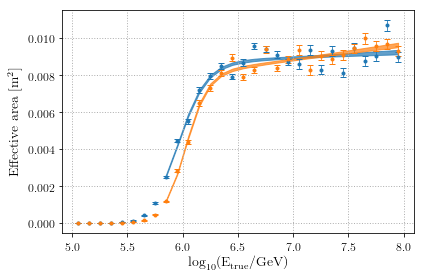

In [54]:
fig, ax = plt.subplots()
for idx, composition in enumerate(comp_list):
    eff = efficiency[:, idx]
    eff_err = efficiency_err[:, idx]
    ax.errorbar(ebin_midpoints, eff, yerr=eff_err, ls='None', color=color_dict[composition], label=composition)
#     ax.plot(ebin_midpoints[emidpoints_fitmask], efficiency_fit[:, idx], marker='None', color=color_dict[composition], label=composition)

#     ax.fill_between(eff_fit['ebin_midpoints'],
#                     eff_fit['eff_mean_{}'.format(composition)] + eff_fit['eff_err_{}'.format(composition)],
#                     eff_fit['eff_mean_{}'.format(composition)] - eff_fit['eff_err_{}'.format(composition)],
# #                 yerr=[eff_fit['eff_err_low_{}'.format(composition)], eff_fit['eff_err_high_{}'.format(composition)]],
# #                     marker='None',
#                     alpha=0.7,
#                     color=color_dict[composition])
    
    ax.fill_between(ebin_midpoints[fit_energy_range_mask],
                    eff_fit[:, idx] + eff_fit_err[:, idx],
                    eff_fit[:, idx] - eff_fit_err[:, idx],
#                 yerr=[eff_fit['eff_err_low_{}'.format(composition)], eff_fit['eff_err_high_{}'.format(composition)]],
#                     marker='None',
                    alpha=0.7,
                    color=color_dict[composition])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Effective area [$\mathrm{m^2}$]')
ax.grid()
plt.show()

In [55]:
unfolding_energy_range_mask = np.logical_and(ebin_midpoints[fit_energy_range_mask] >= energybins.log_energy_min,
                                             ebin_midpoints[fit_energy_range_mask] <= energybins.log_energy_max)
unfolding_energy_range_mask

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [56]:
eff_fit[unfolding_energy_range_mask]

array([[0.00711648, 0.00639353],
       [0.00792472, 0.00747015],
       [0.00837055, 0.00800534],
       [0.00860573, 0.00827011],
       [0.00873291, 0.00842231],
       [0.00880792, 0.00853085],
       [0.0088584 , 0.00862292],
       [0.00889751, 0.00870882],
       [0.00893136, 0.00879243],
       [0.00896279, 0.00887518],
       [0.0089931 , 0.00895761],
       [0.00902289, 0.00903992],
       [0.00905245, 0.00912219],
       [0.0090819 , 0.00920444],
       [0.0091113 , 0.00928668],
       [0.00914067, 0.00936892],
       [0.00917003, 0.00945116],
       [0.00919939, 0.0095334 ],
       [0.00922875, 0.00961564]])

In [57]:
eff_fit_err[unfolding_energy_range_mask]

array([[8.13397477e-05, 8.01800489e-05],
       [6.91328387e-05, 6.62611722e-05],
       [6.56935808e-05, 6.51612713e-05],
       [6.74865410e-05, 6.72383658e-05],
       [6.75351289e-05, 6.58559069e-05],
       [6.48642076e-05, 6.21733524e-05],
       [6.07538957e-05, 5.80999127e-05],
       [5.66647155e-05, 5.49414541e-05],
       [5.37924639e-05, 5.34869241e-05],
       [5.29820066e-05, 5.41167565e-05],
       [5.46297589e-05, 5.68468659e-05],
       [5.86585567e-05, 6.14256342e-05],
       [6.46763936e-05, 6.74864008e-05],
       [7.22070069e-05, 7.46716770e-05],
       [8.08356068e-05, 8.26895213e-05],
       [9.02501055e-05, 9.13210670e-05],
       [1.00229965e-04, 1.00408199e-04],
       [1.10622424e-04, 1.09837902e-04],
       [1.21321494e-04, 1.19529121e-04]])

In [58]:
eff_fit_err[unfolding_energy_range_mask].reshape(-1).shape

(38,)

In [59]:
outfile = os.path.join(os.getcwd(), 'efficienies.npy')
comp.check_output_dir(outfile)
np.save(outfile, eff_fit[unfolding_energy_range_mask])

outfile = os.path.join(os.getcwd(), 'efficienies_err.npy')
comp.check_output_dir(outfile)
np.save(outfile, eff_fit_err[unfolding_energy_range_mask])

In [58]:
# .reset_index(drop=True).to_hdf(eff_outfile, 'dataframe')

In [61]:
import xarray as xr

In [88]:
efficiency_xr = xr.DataArray(efficiency,
                             coords=[ebin_midpoints, np.arange(num_groups)], dims=['reco_log_energy', 'composition'],
                             name='efficiency',
                             attrs={'units': 'log10(E/GeV)'})
efficiency_xr

<xarray.DataArray 'efficiency' (reco_log_energy: 30, composition: 2)>
array([[0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00],
       [3.352813e-06, 1.672608e-06],
       [4.998946e-05, 6.680340e-06],
       [1.166421e-04, 3.168383e-05],
       [4.125110e-04, 1.251620e-04],
       [1.061095e-03, 4.185601e-04],
       [2.472309e-03, 1.151624e-03],
       [4.434118e-03, 2.807981e-03],
       [5.484364e-03, 4.360514e-03],
       [7.180166e-03, 6.478368e-03],
       [7.925337e-03, 7.299088e-03],
       [8.497218e-03, 8.081892e-03],
       [7.907086e-03, 8.933425e-03],
       [8.663219e-03, 7.904954e-03],
       [9.566747e-03, 8.247020e-03],
       [9.395665e-03, 9.372837e-03],
       [9.095354e-03, 8.383204e-03],
       [8.704830e-03, 8.830450e-03],
       [8.575804e-03, 9.340909e-03],
       [9.337900e-03, 8.253968e-03],
       [8.275340e-03, 9.037879e-03],
       [9.286798e-03, 8.835616e-03],
       [8.107903e-03, 9.072948e-03],
     

In [89]:
efficiency_xr.values

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [3.35281283e-06, 1.67260791e-06],
       [4.99894553e-05, 6.68034049e-06],
       [1.16642062e-04, 3.16838287e-05],
       [4.12511025e-04, 1.25161994e-04],
       [1.06109536e-03, 4.18560053e-04],
       [2.47230919e-03, 1.15162405e-03],
       [4.43411791e-03, 2.80798074e-03],
       [5.48436368e-03, 4.36051397e-03],
       [7.18016565e-03, 6.47836781e-03],
       [7.92533676e-03, 7.29908791e-03],
       [8.49721770e-03, 8.08189158e-03],
       [7.90708595e-03, 8.93342498e-03],
       [8.66321873e-03, 7.90495366e-03],
       [9.56674711e-03, 8.24702009e-03],
       [9.39566458e-03, 9.37283737e-03],
       [9.09535407e-03, 8.38320360e-03],
       [8.70482982e-03, 8.83044983e-03],
       [8.57580398e-03, 9.34090909e-03],
       [9.33789954e-03, 8.25396825e-03],
       [8.27534039e-03, 9.03787879e-03],
       [9.28679818e-03, 8.83561644e-03],
       [8.107902

In [90]:
efficiency_xr.name

'efficiency'

In [91]:
efficiency_xr[:10, :]

<xarray.DataArray 'efficiency' (reco_log_energy: 10, composition: 2)>
array([[0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00],
       [3.352813e-06, 1.672608e-06],
       [4.998946e-05, 6.680340e-06],
       [1.166421e-04, 3.168383e-05],
       [4.125110e-04, 1.251620e-04],
       [1.061095e-03, 4.185601e-04],
       [2.472309e-03, 1.151624e-03],
       [4.434118e-03, 2.807981e-03]])
Coordinates:
  * reco_log_energy  (reco_log_energy) float64 5.05 5.15 5.25 5.35 5.45 5.55 ...
  * composition      (composition) int64 0 1
Attributes:
    units:    log10(E/GeV)

In [94]:
efficiency_xr.coords['reco_log_energy'] > 5.8

<xarray.DataArray 'reco_log_energy' (reco_log_energy: 30)>
array([False, False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
  * reco_log_energy  (reco_log_energy) float64 5.05 5.15 5.25 5.35 5.45 5.55 ...

In [96]:
efficiency_xr[efficiency_xr.coords['reco_log_energy'] > 5.8]

<xarray.DataArray 'efficiency' (reco_log_energy: 22, composition: 2)>
array([[0.002472, 0.001152],
       [0.004434, 0.002808],
       [0.005484, 0.004361],
       [0.00718 , 0.006478],
       [0.007925, 0.007299],
       [0.008497, 0.008082],
       [0.007907, 0.008933],
       [0.008663, 0.007905],
       [0.009567, 0.008247],
       [0.009396, 0.009373],
       [0.009095, 0.008383],
       [0.008705, 0.00883 ],
       [0.008576, 0.009341],
       [0.009338, 0.008254],
       [0.008275, 0.009038],
       [0.009287, 0.008836],
       [0.008108, 0.009073],
       [0.009475, 0.009425],
       [0.008741, 0.00997 ],
       [0.009002, 0.009542],
       [0.010678, 0.009652],
       [0.008956, 0.009306]])
Coordinates:
  * reco_log_energy  (reco_log_energy) float64 5.85 5.95 6.05 6.15 6.25 6.35 ...
  * composition      (composition) int64 0 1
Attributes:
    units:    log10(E/GeV)